In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold,cross_val_score,GridSearchCV,RandomizedSearchCV
from colorama import Fore
b_ = Fore.BLUE
c_ = Fore.CYAN
g_ = Fore.GREEN
m_ = Fore.MAGENTA
r_ = Fore.RED
y_ = Fore.YELLOW

In [2]:
def smape(y_true,y_pred):
    smap=np.zeros(len(y_true))
    num=np.abs(y_true-y_pred)
    dem=((np.abs(y_true)+np.abs(y_pred))/2)
    pos_ind=(y_true!=0)|(y_pred!=0)
    smap[pos_ind]=num[pos_ind]/dem[pos_ind]
    return 100*np.mean(smap)

In [3]:
train_proteins=pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
train_peptides=pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv')
train_clincal=pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
data=pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv')

In [4]:
test_proteins=pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv')
test_peptides=pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv')
test=pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test.csv')

In [5]:
train_proteins.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [6]:
train_proteins.isna().sum(),train_peptides.isna().sum()

(visit_id       0
 visit_month    0
 patient_id     0
 UniProt        0
 NPX            0
 dtype: int64,
 visit_id            0
 visit_month         0
 patient_id          0
 UniProt             0
 Peptide             0
 PeptideAbundance    0
 dtype: int64)

In [7]:
train_clincal.isna().sum(),data.isna().sum()

(visit_id                                  0
 patient_id                                0
 visit_month                               0
 updrs_1                                   1
 updrs_2                                   2
 updrs_3                                  25
 updrs_4                                1038
 upd23b_clinical_state_on_medication    1327
 dtype: int64,
 visit_id                                  0
 patient_id                                0
 visit_month                               0
 updrs_1                                 213
 updrs_2                                 214
 updrs_3                                   5
 updrs_4                                 928
 upd23b_clinical_state_on_medication    1101
 dtype: int64)

In [8]:
print(train_proteins.shape,train_peptides.shape,train_clincal.shape,data.shape)

(232741, 5) (981834, 6) (2615, 8) (2223, 8)


<AxesSubplot:>

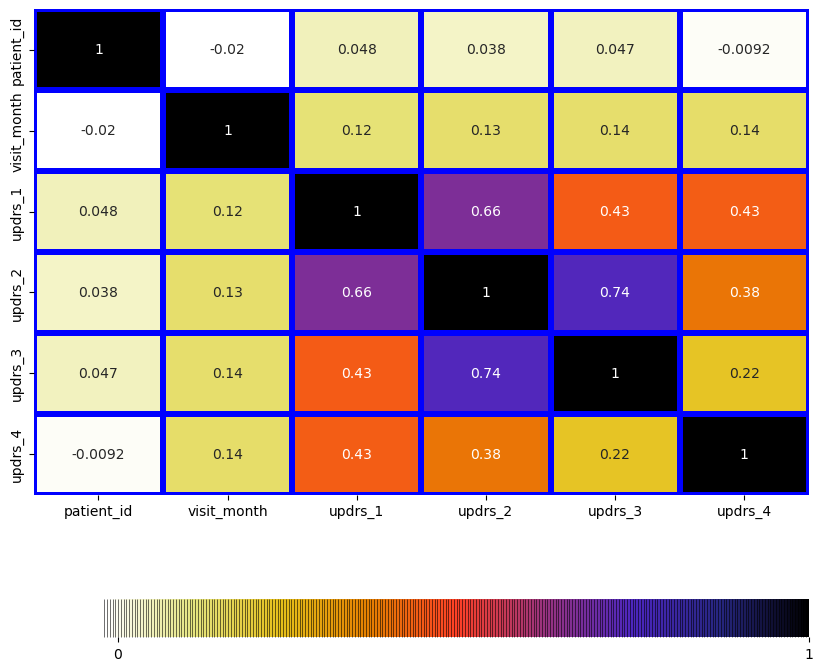

In [9]:
plt.figure(figsize=(10,9))
cbar_kws={
    'orientation':'horizontal',
    'shrink':1,
    'extend':'min',
    'extendfrac':0.1,
    'ticks':np.arange(0,22),
    'drawedges':True
}
sns.heatmap(train_clincal.corr(),cmap=plt.cm.CMRmap_r,annot=True,linewidth=4,linecolor='b',cbar_kws=cbar_kws)

In [10]:
data.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,35_0,35,0,5.0,3.0,16.0,0.0,NaN
1,35_36,35,36,6.0,4.0,20.0,0.0,NaN
2,75_0,75,0,4.0,6.0,26.0,0.0,NaN
3,75_36,75,36,1.0,8.0,38.0,0.0,On
4,155_0,155,0,NaN,NaN,0.0,NaN,NaN


In [11]:
print(test_proteins.shape,test_peptides.shape,test.shape)

(453, 6) (2057, 7) (16, 6)


In [12]:
test.isna().sum(),test_peptides.isna().sum()

(visit_id       0
 visit_month    0
 patient_id     0
 updrs_test     0
 row_id         0
 group_key      0
 dtype: int64,
 visit_id            0
 visit_month         0
 patient_id          0
 UniProt             0
 Peptide             0
 PeptideAbundance    0
 group_key           0
 dtype: int64)

In [13]:
train_proteins.groupby('visit_id').agg({'UniProt':'nunique','patient_id':'count','NPX':['min','max','mean','std']}).reset_index()

visit_id UniProt patient_id       NPX                             \
               nunique      count       min          max          mean   
0      10053_0     165        165  2497.840  269126000.0  2.856580e+06   
1     10053_12     171        171  5800.870  270030000.0  2.728871e+06   
2     10053_18     208        208  1334.110  278835000.0  2.509967e+06   
3     10138_12     217        217  2520.240  365582000.0  3.002583e+06   
4     10138_24     219        219  1436.940  396894000.0  3.068891e+06   
...        ...     ...        ...       ...          ...           ...   
1108   8699_24     216        216   756.551  346067000.0  3.064059e+06   
1109    942_12     212        212  1722.770  330558000.0  2.613298e+06   
1110    942_24     217        217  1339.150  336769000.0  2.616142e+06   
1111    942_48     216        216  1272.480  358059000.0  2.768442e+06   
1112     942_6     216        216  2491.690  290111000.0  2.476880e+06   

                    
               std  
0     2.131630e+07  
1     2.092162e+07  
2     1.969453e+07  
3     2.516170e+07  
4     2.716806e+07  
...            ...  
1108  2.409420e+07  
1109  2.295228e+07  
1110  2.312662e+07  
1111  2.460543e+07  
1112  2.002174e+07  

[1113 rows x 7 columns]

In [14]:
df=train_clincal[(train_clincal.visit_month==0)][['visit_id','updrs_1']]
df.head()

,visit_id,updrs_1
0,55_0,10.0
13,942_0,3.0
28,1517_0,11.0
38,1923_0,2.0
45,2660_0,2.0


In [15]:
fig=px.line_polar(df,r='updrs_1',theta='visit_id',line_close=True,markers=True, direction='clockwise')
fig.show()

In [16]:
proteins_npx_ft =train_proteins.groupby('visit_id').agg(NPX_min=('NPX','min'), NPX_max=('NPX','max'), NPX_mean=('NPX','mean'), NPX_std=('NPX','std'))\
                .reset_index()
proteins_npx_ft.head()

,visit_id,NPX_min,NPX_max,NPX_mean,NPX_std
0,10053_0,2497.84,269126000.0,2.856580e+06,2.131630e+07
1,10053_12,5800.87,270030000.0,2.728871e+06,2.092162e+07
2,10053_18,1334.11,278835000.0,2.509967e+06,1.969453e+07
3,10138_12,2520.24,365582000.0,3.002583e+06,2.516170e+07
4,10138_24,1436.94,396894000.0,3.068891e+06,2.716806e+07


In [17]:
df_proteins = pd.merge(train_proteins, df, on = 'visit_id', how = 'inner').reset_index()
proteins_Uniprot_updrs = df_proteins.groupby('UniProt').agg(updrs_1_sum = ('updrs_1','mean')).reset_index()
proteins_Uniprot_updrs.head()

,UniProt,updrs_1_sum
0,O00391,4.971014
1,O00533,5.319588
2,O00584,5.286458
3,O14498,5.217877
4,O14773,5.371585


In [18]:
df_proteins = pd.merge(train_proteins, proteins_Uniprot_updrs, on = 'UniProt', how = 'left')
proteins_UniProt_ft = df_proteins.groupby('visit_id').agg(proteins_updrs_1_min=('updrs_1_sum','min'), proteins_updrs_1_max=('updrs_1_sum','max'),\
                                                          proteins_updrs_1_mean=('updrs_1_sum','mean'), proteins_updrs_1_std=('updrs_1_sum','std'))\
                .reset_index()
proteins_UniProt_ft.head()

,visit_id,proteins_updrs_1_min,proteins_updrs_1_max,proteins_updrs_1_mean,proteins_updrs_1_std
0,10053_0,4.892857,5.601449,5.300548,0.077355
1,10053_12,4.816794,5.652174,5.296073,0.099055
2,10053_18,4.297619,5.652174,5.272617,0.134631
3,10138_12,4.297619,5.652174,5.263118,0.143238
4,10138_24,4.297619,5.652174,5.269522,0.137776


In [19]:
peptides_PeptideAbundance_ft = train_peptides.groupby('visit_id').agg(Abe_min=('PeptideAbundance','min'), Abe_max=('PeptideAbundance','max'),\
                                                                Abe_mean=('PeptideAbundance','mean'), Abe_std=('PeptideAbundance','std'))\
                .reset_index()
peptides_PeptideAbundance_ft.head()

,visit_id,Abe_min,Abe_max,Abe_mean,Abe_std
0,10053_0,82.9679,66333900.0,726248.393431,3.535602e+06
1,10053_12,128.4460,73059300.0,737183.385744,3.799654e+06
2,10053_18,108.5000,64711200.0,601466.784320,3.006568e+06
3,10138_12,129.0240,71652400.0,699099.199189,3.379573e+06
4,10138_24,142.6480,123897000.0,732120.888877,4.912602e+06


In [20]:
df_peptides = pd.merge(train_peptides, df, on = 'visit_id', how = 'inner').reset_index()
peptides_PeptideAbundance_updrs = df_peptides.groupby('Peptide').agg(updrs_1_sum = ('updrs_1','mean')).reset_index()
peptides_PeptideAbundance_updrs.head()

,Peptide,updrs_1_sum
0,AADDTWEPFASGK,5.357143
1,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,5.296703
2,AAFTEC(UniMod_4)C(UniMod_4)QAADK,5.305699
3,AANEVSSADVK,5.364780
4,AATGEC(UniMod_4)TATVGKR,5.146497


In [21]:
df_peptides = pd.merge(train_peptides, peptides_PeptideAbundance_updrs, on = 'Peptide', how = 'left')
peptides_ft = df_peptides.groupby('visit_id').agg(peptides_updrs_1_min=('updrs_1_sum','min'), peptides_updrs_1_max=('updrs_1_sum','max'),\
                                                          peptides_updrs_1_mean=('updrs_1_sum','mean'), peptides_updrs_1_std=('updrs_1_sum','std'))\
                .reset_index()
peptides_ft

,visit_id,peptides_updrs_1_min,peptides_updrs_1_max,peptides_updrs_1_mean,peptides_updrs_1_std
0,10053_0,4.878788,5.661972,5.279278,0.092880
1,10053_12,4.816794,5.661972,5.277513,0.097712
2,10053_18,4.297619,5.661972,5.265384,0.116303
3,10138_12,4.297619,5.661972,5.253513,0.126117
4,10138_24,4.297619,5.661972,5.257710,0.123452
...,...,...,...,...,...
1108,8699_24,4.572519,5.661972,5.256902,0.123395
1109,942_12,4.572519,5.661972,5.254323,0.118205
1110,942_24,4.572519,5.652174,5.255565,0.117226
1111,942_48,4.572519,5.652174,5.253489,0.119653


In [22]:
df_0_1 = train_clincal[(train_clincal.visit_month == 3)][['visit_id','updrs_1']]
df_0_2 = train_clincal[(train_clincal.visit_month == 3)][['visit_id','updrs_2']]
df_0_3 = train_clincal[(train_clincal.visit_month == 3)][['visit_id','updrs_3']]
df_0_4 = train_clincal[(train_clincal.visit_month == 3)][['visit_id','updrs_4']]

df_proteins = pd.merge(train_proteins, df_0_1, on = 'visit_id', how = 'inner').reset_index()
proteins_Uniprot_updrs1 = df_proteins.groupby('UniProt').agg(updrs_1_sum = ('updrs_1','mean')).reset_index()

df_proteins = pd.merge(train_proteins, df_0_2, on = 'visit_id', how = 'inner').reset_index()
proteins_Uniprot_updrs2 = df_proteins.groupby('UniProt').agg(updrs_1_sum = ('updrs_2','mean')).reset_index()

df_proteins = pd.merge(train_proteins, df_0_3, on = 'visit_id', how = 'inner').reset_index()
proteins_Uniprot_updrs3 = df_proteins.groupby('UniProt').agg(updrs_1_sum = ('updrs_3','mean')).reset_index()

df_proteins = pd.merge(train_proteins, df_0_4, on = 'visit_id', how = 'inner').reset_index()
proteins_Uniprot_updrs4 = df_proteins.groupby('UniProt').agg(updrs_1_sum = ('updrs_4','mean')).reset_index()

df_peptides = pd.merge(train_peptides, df_0_1, on = 'visit_id', how = 'inner').reset_index()
peptides_PeptideAbundance_updrs1 = df_peptides.groupby('Peptide').agg(updrs_1_sum = ('updrs_1','mean')).reset_index()

df_peptides = pd.merge(train_peptides, df_0_2, on = 'visit_id', how = 'inner').reset_index()
peptides_PeptideAbundance_updrs2 = df_peptides.groupby('Peptide').agg(updrs_1_sum = ('updrs_2','mean')).reset_index()

df_peptides = pd.merge(train_peptides, df_0_3, on = 'visit_id', how = 'inner').reset_index()
peptides_PeptideAbundance_updrs3 = df_peptides.groupby('Peptide').agg(updrs_1_sum = ('updrs_3','mean')).reset_index()

df_peptides = pd.merge(train_peptides, df_0_4, on = 'visit_id', how = 'inner').reset_index()
peptides_PeptideAbundance_updrs4 = df_peptides.groupby('Peptide').agg(updrs_1_sum = ('updrs_4','mean')).reset_index()

df_proteins_fts = [proteins_Uniprot_updrs1, proteins_Uniprot_updrs2, proteins_Uniprot_updrs3, proteins_Uniprot_updrs4]
df_peptides_fts = [peptides_PeptideAbundance_updrs1, peptides_PeptideAbundance_updrs2, peptides_PeptideAbundance_updrs3, peptides_PeptideAbundance_updrs4]
df_lst = [df_0_1, df_0_2, df_0_3, df_0_4]

In [23]:
def features(df, train_proteins, train_peptides, classes):
    proteins_npx_ft = train_proteins.groupby('visit_id').agg(NPX_min=('NPX','min'), NPX_max=('NPX','max'), NPX_mean=('NPX','mean'), NPX_std=('NPX','std'))\
                    .reset_index()
    peptides_PeptideAbundance_ft = train_peptides.groupby('visit_id').agg(Abe_min=('PeptideAbundance','min'), Abe_max=('PeptideAbundance','max'),\
                                                                    Abe_mean=('PeptideAbundance','mean'), Abe_std=('PeptideAbundance','std'))\
                    .reset_index()

    df_proteins = pd.merge(train_proteins, df_proteins_fts[classes], on = 'UniProt', how = 'left')
    proteins_UniProt_ft = df_proteins.groupby('visit_id').agg(proteins_updrs_1_min=('updrs_1_sum','min'), proteins_updrs_1_max=('updrs_1_sum','max'),\
                                                              proteins_updrs_1_mean=('updrs_1_sum','mean'), proteins_updrs_1_std=('updrs_1_sum','std'))\
                    .reset_index()
    df_peptides = pd.merge(train_peptides, df_peptides_fts[classes], on = 'Peptide', how = 'left')
    peptides_ft = df_peptides.groupby('visit_id').agg(peptides_updrs_1_min=('updrs_1_sum','min'), peptides_updrs_1_max=('updrs_1_sum','max'),\
                                                              peptides_updrs_1_mean=('updrs_1_sum','mean'), peptides_updrs_1_std=('updrs_1_sum','std'))\
                    .reset_index()

    df = pd.merge(df, proteins_npx_ft, on = 'visit_id', how = 'left')
    df = pd.merge(df, peptides_PeptideAbundance_ft, on = 'visit_id', how = 'left')
    df = pd.merge(df, proteins_UniProt_ft, on = 'visit_id', how = 'left')
    df = pd.merge(df, peptides_ft, on = 'visit_id', how = 'left')
    df = df.fillna(df.mean())
    return df

In [24]:
train_0 = features(df_0_1, train_proteins, train_peptides, 0)
train_0

,visit_id,updrs_1,NPX_min,NPX_max,NPX_mean,NPX_std,Abe_min,Abe_max,Abe_mean,Abe_std,proteins_updrs_1_min,proteins_updrs_1_max,proteins_updrs_1_mean,proteins_updrs_1_std,peptides_updrs_1_min,peptides_updrs_1_max,peptides_updrs_1_mean,peptides_updrs_1_std
0,55_3,10.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0
1,942_3,7.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0
2,3636_3,4.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0
3,4161_3,1.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0
4,5645_3,5.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,62723_3,7.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0
111,62792_3,0.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0
112,64669_3,15.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0
113,64674_3,5.0,507.771,201446000.0,2.123204e+06,1.448782e+07,75.9736,59282500.0,500980.873898,2.490907e+06,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0


In [25]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

from sklearn.metrics import confusion_matrix,precision_score,recall_score,classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR  
from xgboost import XGBRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import optuna

In [26]:
model = {}
mms = MinMaxScaler()
n_estimators = list(range(800,3000)) # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 150, num = 30)] # maximum number of levels allowed in each decision tree
min_samples_split = list(range(5,40)) # minimum sample number to split a node
min_samples_leaf = list(range(5,40)) # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points


for i in range(3):
    print('--------------------------------------------------------')
    print('Model {0}'.format(i + 1))
    train_0 = features(df_lst[i], train_proteins, train_peptides, i)
    scale_col = ['NPX_min','NPX_max','NPX_mean','NPX_std', 'Abe_min', 'Abe_max', 'Abe_mean', 'Abe_std']
    train_0[scale_col] = mms.fit_transform(train_0[scale_col])
    
    rfc = RandomForestRegressor()
    svc = SVR()
    ln = Lasso()
    dt = DecisionTreeRegressor()
    xg1= XGBRegressor()
    lgbm =LGBMRegressor()
    cat=CatBoostRegressor()
    params = [{
        'min_child_weight': [1, 5,6,7,10],
        'gamma': [0.5, 1, 1.5, 5,8,9,11,17],
        'subsample': [0.6, 0.8, 0.9,1.0],
        'colsample_bytree': [0.6,0.5, 0.8,0.9, 1.0],
        'max_depth': [ 7,9,11,13,17,19,21,22,37,41],
        'n_estimators': [800,974,1310,1700,1200,2020,2440,2500],
        'learning_rate': [0.00001, 0.1,0.02,0.0002,0.3,0.000035,0.05,0.005,0.004,0.04,0.006,0.06,0.07,0.007],
        }]
    param_cat =[{
                  'depth'         : [6,8,10,11,17],
                  'learning_rate' : [0.01, 0.05, 0.1,0.3,0.5],
                  #'iterations'    : [ 500,800,1200,2020, 2500]
                }]
    param_lgb = [{
    'n_estimators': [100, 500,800,1200,2020,2500],
    'learning_rate': [0.05, 0.1, 0.002,0.01,0.02,0.035,0.5,0.005],
    'max_depth': [3, 5, 7,9,11,13,17]
    }]
    
    svc_params = [{'kernel':['poly','rbf','sigmoid','linear']}]
    forest_params = [{'n_estimators': n_estimators,

    'max_features': max_features,

    'max_depth': max_depth,

    'min_samples_split': min_samples_split,

    'min_samples_leaf': min_samples_leaf,

    'bootstrap': bootstrap}]
    linear_params = [{'alpha':[0.00001,0.002,0.0003,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.001,0.0001,0.003,0.005]}]
    tree_params = [{

    'max_features': max_features,

    'max_depth': max_depth,

    'min_samples_split': min_samples_split,

    'min_samples_leaf': min_samples_leaf}]
    
     
     
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    clf = RandomizedSearchCV(rfc, forest_params, cv = cv, scoring=make_scorer(smape), verbose = -1)
    svc = RandomizedSearchCV(svc, svc_params, cv = cv, scoring=make_scorer(smape), verbose = -1)
    linear = RandomizedSearchCV(ln, linear_params, cv = cv, scoring=make_scorer(smape), verbose = -1)
#  cat = RandomizedSearchCV(cat, param_cat, cv = cv, scoring=make_scorer(smape), verbose = -1)
    xgb= RandomizedSearchCV(xg1, params, cv = cv, scoring=make_scorer(smape), verbose = -1)
    
    X = train_0.drop(columns = ['visit_id','updrs_{0}'.format(i + 1)], axis = 1)
    y = train_0['updrs_{0}'.format(i + 1)].astype(np.float32)
   # cat.fit(X,y)
    clf.fit(X, y)
    svc.fit(X,y)
    linear.fit(X,y)
    
    xgb.fit(X,y)

    print('rfc best params:',clf.best_params_)

    print('rfc best score',clf.best_score_)
    
    print('svc best param',svc.best_params_)

    print('svc best score',svc.best_score_)
    
    print('linear best param',linear.best_params_)

    print('linear best score',linear.best_score_)
    
    #print('lgbm best param',cat.best_params_)

   # print('lgbm best score',cat.best_score_)
    print('xgb best score',xgb.best_params_)
    print("XGBOOST",xgb.best_score_)
    
    print('Train smape rfc:',smape(train_0['updrs_{0}'.format(i + 1)], clf.predict(train_0.drop(columns = ['visit_id','updrs_{0}'.format(i + 1)], axis = 1))))
    print('Train smape svc:',smape(train_0['updrs_{0}'.format(i + 1)], svc.predict(train_0.drop(columns = ['visit_id','updrs_{0}'.format(i + 1)], axis = 1))))
    print('Train smape linear:',smape(train_0['updrs_{0}'.format(i + 1)], linear.predict(train_0.drop(columns = ['visit_id','updrs_{0}'.format(i + 1)], axis = 1))))
    #print('Train smape lgbm:',smape(train_0['updrs_{0}'.format(i + 1)], cat.predict(train_0.drop(columns = ['visit_id','updrs_{0}'.format(i + 1)], axis = 1))))
    print('Boosting :',smape(train_0['updrs_{0}'.format(i + 1)], xgb.predict(train_0.drop(columns = ['visit_id','updrs_{0}'.format(i + 1)], axis = 1))))
    
    
    model['rfc_' + str(i)] = clf
    model['svc_'+str(i)]=svc
    model['linear_' + str(i)] = linear
    #model['lgbm_' + str(i)] = cat
    model['xgb_' + str(i)]=xgb

--------------------------------------------------------
Model 1


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning:

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.



rfc best params: {'n_estimators': 2946, 'min_samples_split': 22, 'min_samples_leaf': 15, 'max_features': 'auto', 'max_depth': 121, 'bootstrap': True}
rfc best score 71.43358211706206
svc best param {'kernel': 'rbf'}
svc best score 71.75552241110057
linear best param {'alpha': 0.04}
linear best score 71.43109434656283
xgb best score {'subsample': 0.6, 'n_estimators': 2440, 'min_child_weight': 5, 'max_depth': 13, 'learning_rate': 0.02, 'gamma': 5, 'colsample_bytree': 0.8}
XGBOOST 71.55315669987237
Train smape rfc: 70.4548681208368
Train smape svc: 70.49687673914481
Train smape linear: 70.46046849710056
Boosting : 70.33765498125723
--------------------------------------------------------
Model 2


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning:

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.



rfc best params: {'n_estimators': 2620, 'min_samples_split': 20, 'min_samples_leaf': 13, 'max_features': 'sqrt', 'max_depth': 87, 'bootstrap': True}
rfc best score 65.38085520432486
svc best param {'kernel': 'poly'}
svc best score 63.45952754747729
linear best param {'alpha': 0.1}
linear best score 65.37065411301134
xgb best score {'subsample': 0.6, 'n_estimators': 1310, 'min_child_weight': 7, 'max_depth': 37, 'learning_rate': 1e-05, 'gamma': 5, 'colsample_bytree': 0.6}
XGBOOST 151.28027006532204
Train smape rfc: 64.58574524570332
Train smape svc: 62.980791845029884
Train smape linear: 64.58294234685054
Boosting : 151.34972290618248
--------------------------------------------------------
Model 3


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning:

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.



rfc best params: {'n_estimators': 2814, 'min_samples_split': 26, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 53, 'bootstrap': True}
rfc best score 41.29264154850057
svc best param {'kernel': 'poly'}
svc best score 40.95989572174327
linear best param {'alpha': 0.06}
linear best score 41.29168464599189
xgb best score {'subsample': 0.6, 'n_estimators': 1700, 'min_child_weight': 6, 'max_depth': 22, 'learning_rate': 1e-05, 'gamma': 9, 'colsample_bytree': 0.5}
XGBOOST 176.72389207464278
Train smape rfc: 40.97025145843898
Train smape svc: 40.731509759889704
Train smape linear: 40.97371259266178
Boosting : 176.8926663619319


In [27]:
updrs_3_pred = {}
up3 = train_clincal[['visit_month','updrs_3']].drop_duplicates(['visit_month','updrs_3'])
updrs_3_pred = dict(zip(up3.visit_month, up3.updrs_3))
updrs_3_pred

{0: 27.0,
 3: 31.0,
 6: 41.0,
 9: 31.0,
 12: 45.0,
 18: 14.0,
 24: 41.0,
 30: 38.0,
 36: 44.0,
 42: 48.0,
 48: 8.0,
 54: 57.0,
 60: 44.0,
 72: 51.0,
 84: 41.0,
 96: 5.0,
 108: 35.0}

In [28]:
import amp_pd_peptide
env = amp_pd_peptide.make_env()   
iter_test = env.iter_test()

In [29]:
def map_test(x):
    updrs = x.split('_')[2] + '_' + x.split('_')[3]
    month = int(x.split('_plus_')[1].split('_')[0])
    visit_id = x.split('_')[0] + '_' + x.split('_')[1]
    # set all predictions 0 where updrs equals 'updrs_4'
    if updrs=='updrs_3':
#         rating = updrs_3_pred[month]
        rating = df[df.visit_id == visit_id]['pred2'].values[0]
    elif updrs=='updrs_4':
        rating = 0
    elif updrs =='updrs_1':
        rating = df[df.visit_id == visit_id]['pred0'].values[0]
    else:
        rating = df[df.visit_id == visit_id]['pred1'].values[0]
    return rating

counter = 0
# The API will deliver four dataframes in this specific order:
for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    df = test[['visit_id']].drop_duplicates('visit_id')
    pred_0 = features(df[['visit_id']], test_proteins, test_peptides, 0)
    scale_col = ['NPX_min','NPX_max','NPX_mean','NPX_std', 'Abe_min', 'Abe_max', 'Abe_mean', 'Abe_std']
    pred_0[scale_col] = mms.fit_transform(pred_0[scale_col])
    pred_0 = (model['rfc_0'].predict(pred_0.drop(columns = ['visit_id'], axis = 1)) \
              + model['svc_0'].predict(pred_0.drop(columns = ['visit_id'], axis = 1))\
                 + model['linear_0'].predict(pred_0.drop(columns = ['visit_id'], axis = 1))\
                     #+ model['lgbm_0'].predict(pred_0.drop(columns = ['visit_id'], axis = 1))\
                        +model['xgb_0'].predict(pred_0.drop(columns = ['visit_id'], axis = 1)))/4
    df['pred0'] = np.ceil(pred_0 + 0)
    
    pred_1 = features(df[['visit_id']], test_proteins, test_peptides, 1)
    scale_col = ['NPX_min','NPX_max','NPX_mean','NPX_std', 'Abe_min', 'Abe_max', 'Abe_mean', 'Abe_std']
    pred_1[scale_col] = mms.fit_transform(pred_1[scale_col])
    pred_1 = (model['rfc_1'].predict(pred_1.drop(columns = ['visit_id'], axis = 1)) \
              +model['svc_1'].predict(pred_1.drop(columns = ['visit_id'], axis = 1))\
                 + model['linear_1'].predict(pred_1.drop(columns = ['visit_id'], axis = 1))\
                   +model['xgb_1'].predict(pred_1.drop(columns = ['visit_id'], axis = 1)))/4
                     #+ model['lgbm_1'].predict(pred_1.drop(columns = ['visit_id'], axis = 1)))/5
    df['pred1'] = np.ceil(pred_1 + 0.5)
    
    pred_2 = features(df[['visit_id']], test_proteins, test_peptides, 2)
    scale_col = ['NPX_min','NPX_max','NPX_mean','NPX_std', 'Abe_min', 'Abe_max', 'Abe_mean', 'Abe_std']
    pred_2[scale_col] = mms.fit_transform(pred_2[scale_col])
    pred_2 = (model['rfc_2'].predict(pred_2.drop(columns = ['visit_id'], axis = 1)) \
                +model['svc_2'].predict(pred_2.drop(columns = ['visit_id'], axis = 1))\
                    + model['linear_2'].predict(pred_2.drop(columns = ['visit_id'], axis = 1))\
                       + model['xgb_2'].predict(pred_2.drop(columns = ['visit_id'], axis = 1)))/4
                         #+ model['lgbm_2'].predict(pred_2.drop(columns = ['visit_id'], axis = 1)))/5
    df['pred2'] = np.ceil(pred_2 + 1.5)
    
    sample_submission['rating'] = sample_submission['prediction_id'].apply(map_test)
    env.predict(sample_submission)
    
    if counter == 0:
        display(test)
        display(sample_submission)
        
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


,visit_id,visit_month,patient_id,updrs_test,row_id
0,3342_0,0,3342,updrs_1,3342_0_updrs_1
1,3342_0,0,3342,updrs_2,3342_0_updrs_2
2,3342_0,0,3342,updrs_3,3342_0_updrs_3
3,3342_0,0,3342,updrs_4,3342_0_updrs_4
4,50423_0,0,50423,updrs_1,50423_0_updrs_1
5,50423_0,0,50423,updrs_2,50423_0_updrs_2
6,50423_0,0,50423,updrs_3,50423_0_updrs_3
7,50423_0,0,50423,updrs_4,50423_0_updrs_4


,prediction_id,rating
0,3342_0_updrs_1_plus_0_months,6.0
1,3342_0_updrs_1_plus_6_months,6.0
2,3342_0_updrs_1_plus_12_months,6.0
3,3342_0_updrs_1_plus_24_months,6.0
4,3342_0_updrs_2_plus_0_months,6.0
5,3342_0_updrs_2_plus_6_months,6.0
6,3342_0_updrs_2_plus_12_months,6.0
7,3342_0_updrs_2_plus_24_months,6.0
8,3342_0_updrs_3_plus_0_months,17.0
9,3342_0_updrs_3_plus_6_months,17.0
